# Trabalho Final (Parte 2) - Modelagem e Avaliação (ML)
**Disciplina:** Introdução ao Aprendizado de Máquina  
**Alunos:** Elisangela Oliveira, Glauco Neto, Wellington Gomes

---
## 1. Definição do Problema e Abordagem

**Objetivo:** Classificar a **Causa Básica do Óbito** (variável `CAUSABAS`) com base em características demográficas.

**Estratégia de Modelagem:**
Baseado nos notebooks da disciplina, utilizaremos a seguinte abordagem:
1.  **Pré-processamento:** Limpeza e *Encoding* (OneHot/Label) conforme visto em `CMPINAM-03`.
2.  **Baseline:** **Regressão Logística**, conforme estudado em `CMPINAM-06`, para estabelecer um desempenho base linear.
3.  **Modelos Não-Lineares:** **Random Forest** e **XGBoost**, comparando com a baseline para capturar interações complexas, seguindo a lógica de `Logistic_regression_vs_decision_trees`.
4.  **Otimização:** **GridSearchCV** com **StratifiedKFold** para garantir robustez na validação, conforme `CMPINAM-08`.

**Relevância:**
A classificação automática ou assistida da causa de morte pode ajudar a identificar padrões de mortalidade em tempo real, auxiliar na auditoria de óbitos mal definidos e direcionar políticas públicas preventivas para grupos de risco específicos identificados na Parte 1 (EDA).

**Abordagem:**
Trata-se de um problema de **Classificação Multiclasse**. Dado o desbalanceamento das classes (algumas doenças matam muito mais que outras), utilizaremos técnicas de balanceamento (SMOTE) e métricas que ponderem essas diferenças (F1-Score Weighted e AUC).

In [3]:
# Bibliotecas de Manipulação e Visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
import os

# Pré-processamento e Validação
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Configurações
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# Função de carregamento (Reutilizada da Parte 1)
def carregar_dados(url_zip, nome_csv, cache_local=True):
    # Força a remoção do arquivo local para garantir que o CSV completo (com todas as colunas) seja baixado
    if cache_local and os.path.exists(nome_csv):
        print(f"Removendo arquivo local antigo '{nome_csv}' para garantir download dos dados brutos...")
        try:
            os.remove(nome_csv)
        except OSError as e:
            print(f"Erro ao remover arquivo: {e}")

    print("Baixando e carregando dados do DATASUS...")
    try:
        response = requests.get(url_zip, stream=True)
        response.raise_for_status()

        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            # Tenta abrir o arquivo CSV dentro do ZIP
            with zip_file.open(nome_csv) as csv_file:
                # Ajuste crucial: quotechar='"' e delimiter=';' (ou ',' dependendo da versão do arquivo)
                # O arquivo DO24OPEN.csv muitas vezes usa aspas para todos os campos
                df = pd.read_csv(
                    csv_file,
                    delimiter=';',  # Tente ';' primeiro. Se falhar, o código abaixo tenta ','
                    low_memory=False,
                    encoding='latin1',
                    quotechar='"'
                )

        # Verifica se o carregamento foi bem sucedido (se as colunas estão separadas)
        if len(df.columns) <= 1:
             # Se falhou (tudo em uma coluna), tenta com vírgula
            print("Aviso: Delimitador ';' parece incorreto. Tentando com vírgula...")
            # Re-download não é necessário se tivéssemos guardado o buffer, mas para simplificar:
            response = requests.get(url_zip, stream=True)
            with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
                with zip_file.open(nome_csv) as csv_file:
                     df = pd.read_csv(
                        csv_file,
                        delimiter=',',
                        low_memory=False,
                        encoding='latin1',
                        quotechar='"'
                    )

        if cache_local:
            # Salva localmente já limpo e padronizado com ponto e vírgula
            df.to_csv(nome_csv, index=False, sep=';', encoding='latin1')

        return df

    except Exception as e:
        print(f"Erro fatal ao carregar dados: {e}")
        return None

# Execução do carregamento
url_zip = "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/csv/DO24OPEN_csv.zip"
df = carregar_dados(url_zip, 'DO24OPEN.csv')

if df is not None:
    # Engenharia de Features Inicial (Trazida da Parte 1)
    # Verifica se as colunas necessárias existem
    if 'DTOBITO' in df.columns and 'DTNASC' in df.columns:
        df['DTOBITO'] = pd.to_datetime(df['DTOBITO'], format='%d%m%Y', errors='coerce')
        df['DTNASC'] = pd.to_datetime(df['DTNASC'], format='%d%m%Y', errors='coerce')
        df['IDADE_CALCULADA'] = (df['DTOBITO'] - df['DTNASC']).dt.days / 365.25
        df = df.dropna(subset=['IDADE_CALCULADA']) # Remove erros de data
        print(f"Dados carregados com sucesso! Registros válidos: {len(df)}")
        print(f"Colunas disponíveis: {list(df.columns)}")
    else:
        print("ERRO: Colunas de data (DTOBITO/DTNASC) não encontradas no arquivo.")

Baixando e carregando dados do DATASUS...
Aviso: Delimitador ';' parece incorreto. Tentando com vírgula...
Dados carregados com sucesso! Registros válidos: 1509176
Colunas disponíveis: ['ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURALID', 'CODMUNNATU', 'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'ESC2010', 'SERIESCFAL', 'OCUP', 'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'ESTABDESCR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'ESCMAE2010', 'SERIESCMAE', 'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'SEMAGESTAC', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO', 'TPMORTEOCO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA', 'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS', 'CB_PRE', 'COMUNSVOIM', 'DTATESTADO', 'CIRCOBITO', 'ACIDTRAB', 'FONTE', 'NUMEROLOTE', 'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'ATESTANTE', 'STCODIFICA', 'CODIFICADO', 'VERSAOSIST', 'VERSAOSCB', 'FONTEINV', 'DTRECEBIM', 'ATESTADO', 'DTRECORIGA', 'CAUSAMAT', 'ESCMAEAGR1'

## 2. Preparação dos Dados e Engenharia de Features

Nesta etapa, realizamos as transformações necessárias para que os algoritmos possam processar os dados:

1.  **Seleção de Features:** Focamos em atributos que não revelam a causa da morte a posteriori (ex: evitamos usar dados de autópsia que confirmam a morte).
2.  **Tratamento do Target:** A variável `CAUSABAS` possui centenas de códigos CID-10. Para viabilizar a classificação, agrupamos nas **10 causas mais frequentes**, rotulando as demais como 'Outras'.
3.  **Encoding:** Transformação de variáveis categóricas (Sexo, Raça, etc.) em números.
4.  **Balanceamento (SMOTE):** Como visto na EDA, há grande disparidade entre as classes. O SMOTE cria exemplos sintéticos da classe minoritária para evitar viés do modelo.
5.  **Normalização:** Padronização da escala para modelos sensíveis a magnitude (como Regressão Logística).

In [5]:
# 1. Seleção e Limpeza
# Verifica se todas as colunas desejadas estão no dataframe
variaveis_desejadas = ['IDADE_CALCULADA', 'SEXO', 'RACACOR', 'ESC2010', 'LOCOCOR', 'CIRCOBITO', 'CAUSABAS']
colunas_existentes = [col for col in variaveis_desejadas if col in df.columns]

if len(colunas_existentes) < len(variaveis_desejadas):
    print(f"Aviso: Algumas colunas não foram encontradas e serão ignoradas: {set(variaveis_desejadas) - set(colunas_existentes)}")

df_model = df[colunas_existentes].copy().dropna()

# 2. Definição do Alvo (Agrupamento)
# Se a coluna alvo não existir, paramos
if 'CAUSABAS' in df_model.columns:
    top_causas = df_model['CAUSABAS'].value_counts().head(10).index
    df_model['TARGET'] = df_model['CAUSABAS'].apply(lambda x: x if x in top_causas else 'Outras')

    # 3. Separação X e y
    X = df_model.drop(['CAUSABAS', 'TARGET'], axis=1)
    y_raw = df_model['TARGET']

    # Encoding do Target
    le_target = LabelEncoder()
    y = le_target.fit_transform(y_raw)

    # Encoding das Features (Label Encoding para simplificar modelos baseados em árvore)
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

    # 4. Divisão Treino/Teste (Holdout 70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Balanceamento (SMOTE) - Apenas no treino para evitar data leakage
    print("Aplicando SMOTE (Synthetic Minority Over-sampling Technique)...")
    # Nota: O SMOTE pode ser pesado se o dataset for gigante.
    # Se demorar muito, considere usar uma amostra dos dados para teste (ex: df.sample(50000))
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

    # 6. Normalização (StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_test_scaled = scaler.transform(X_test) # Usa a média/dp do treino

    print(f"Dados de Treino Balanceados: {X_train_scaled.shape}")
    print(f"Dados de Teste: {X_test_scaled.shape}")
else:
    print("ERRO: Variável alvo 'CAUSABAS' não encontrada.")

Aplicando SMOTE (Synthetic Minority Over-sampling Technique)...
Dados de Treino Balanceados: (725252, 6)
Dados de Teste: (43581, 6)


## 3. Algoritmos de Machine Learning

Selecionamos três abordagens distintas para comparação:

1.  **Regressão Logística (Logistic Regression):**
    * *Tipo:* Modelo linear probabilístico.
    * *Motivação:* Serve como **Baseline**. É interpretável e rápido, mas assume linearidade entre as features e o log-odds das classes.

2.  **Random Forest (Floresta Aleatória):**
    * *Tipo:* Ensemble de Bagging (várias árvores de decisão independentes).
    * *Motivação:* Lida bem com relações não lineares e interações entre variáveis (ex: idade e escolaridade). Geralmente robusto a outliers e overfitting.

3.  **XGBoost (Extreme Gradient Boosting):**
    * *Tipo:* Ensemble de Boosting (árvores sequenciais que corrigem erros das anteriores).
    * *Motivação:* Estado da arte para dados tabulares. Oferece alto desempenho preditivo, embora exija maior ajuste de hiperparâmetros.

### 3.1 Metodologia de Avaliação
Para cada modelo, utilizamos **Grid Search com Cross-Validation (CV)** para encontrar os melhores hiperparâmetros, otimizando a métrica **F1-Score Weighted** (adequada para multiclasse com desbalanceamento residual).

In [6]:
def avaliar_modelo(modelo, X_test, y_test, nome_modelo, le_target):
    """Gera métricas, matriz de confusão e relatório"""
    from time import time

    # Predição
    inicio = time()
    y_pred = modelo.predict(X_test)
    try:
        y_proba = modelo.predict_proba(X_test)
    except:
        y_proba = None
    tempo_pred = time() - inicio

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

    # AUC (se disponível probabilidade)
    auc_val = None
    if y_proba is not None:
        try:
            auc_val = roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class='ovr', average='weighted')
        except:
            pass

    print(f"--- {nome_modelo} ---")
    print(f"Acurácia: {acc:.4f} | F1-Score: {f1:.4f} | AUC: {auc_val if auc_val else 'N/A'}")
    print(f"Tempo de Predição: {tempo_pred:.4f}s")

    # Matriz de Confusão
    plt.figure(figsize=(10, 8))
    # Reverte os números para os nomes das causas para o gráfico ficar legível
    nomes_classes = le_target.inverse_transform(sorted(list(set(y_test))))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=nomes_classes, yticklabels=nomes_classes)
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return {'Modelo': nome_modelo, 'Acurácia': acc, 'Precision': p, 'Recall': r, 'F1': f1, 'AUC': auc_val}

Otimizando Regressão Logística...
--- Regressão Logística ---
Acurácia: 0.2328 | F1-Score: 0.2061 | AUC: 0.605977362608208
Tempo de Predição: 0.0299s


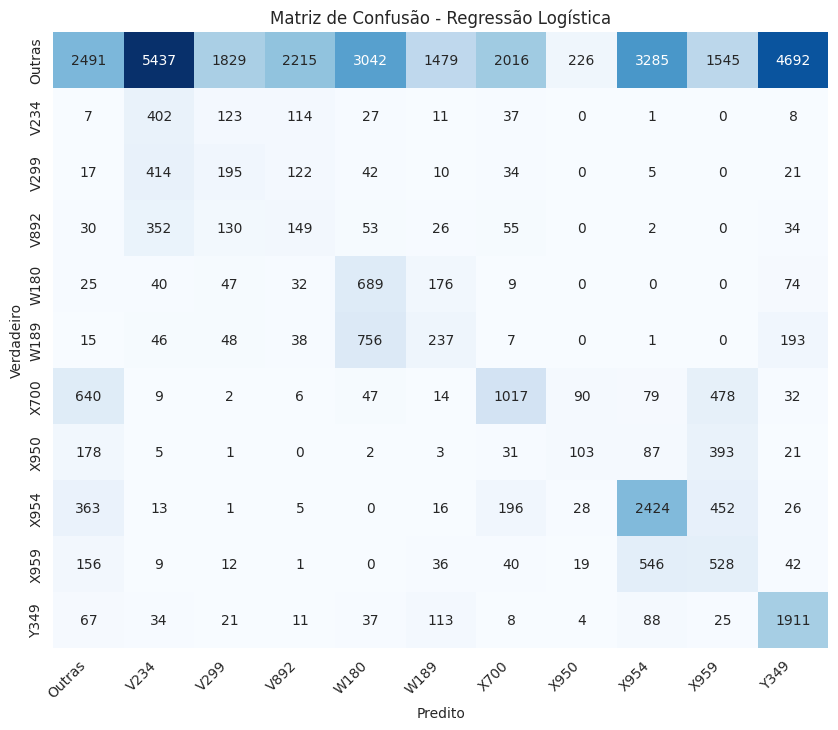


Otimizando Random Forest...
--- Random Forest ---
Acurácia: 0.6858 | F1-Score: 0.6366 | AUC: 0.7809507359701773
Tempo de Predição: 1.5168s


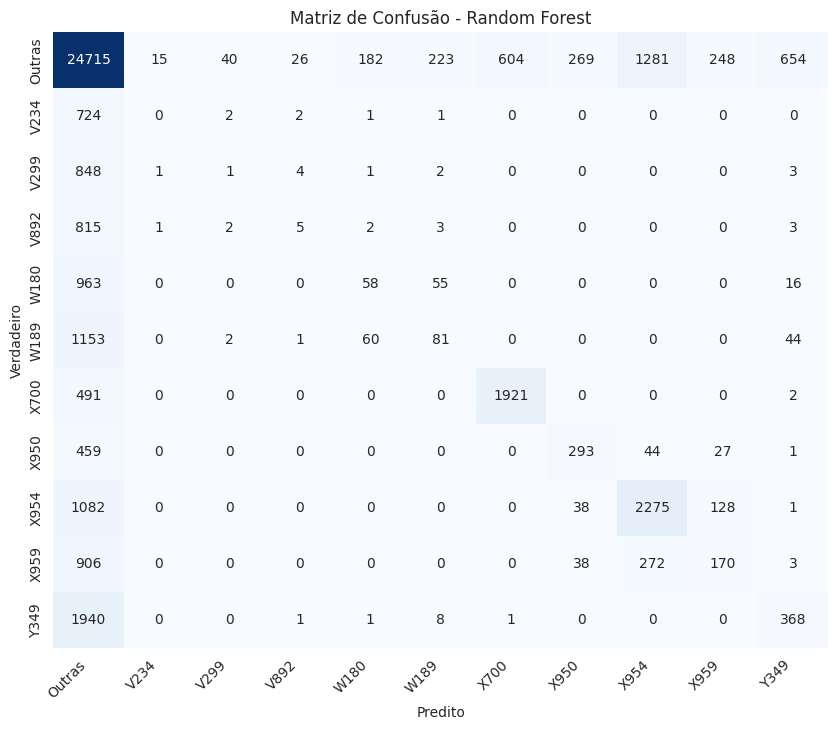


Otimizando XGBoost...
--- XGBoost ---
Acurácia: 0.7113 | F1-Score: 0.6357 | AUC: 0.8136906676845086
Tempo de Predição: 1.4003s


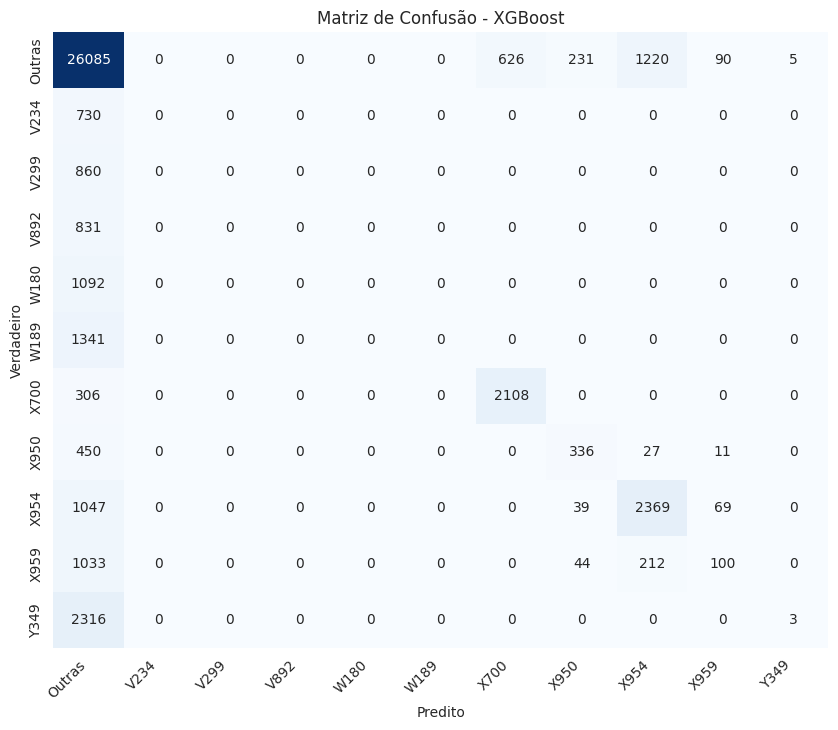

In [7]:
# Dicionário para guardar resultados
resultados_finais = []

# --- Modelo 1: Regressão Logística ---
print("Otimizando Regressão Logística...")
# Nota: Reduzimos o grid para agilizar a execução em aula/teste. Aumente max_iter se não convergir.
params_lr = {'C': [1, 10], 'solver': ['lbfgs']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), params_lr, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train_bal)

res_lr = avaliar_modelo(grid_lr.best_estimator_, X_test_scaled, y_test, 'Regressão Logística', le_target)
resultados_finais.append(res_lr)

# --- Modelo 2: Random Forest ---
print("\nOtimizando Random Forest...")
# Nota: n_estimators reduzido para 50 para rapidez. Em produção, usaríamos 100+
params_rf = {'n_estimators': [50], 'max_depth': [10, 20], 'min_samples_split': [5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), params_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train) # RF não precisa de dados normalizados (scaled), mas funciona com eles

res_rf = avaliar_modelo(grid_rf.best_estimator_, X_test, y_test, 'Random Forest', le_target)
resultados_finais.append(res_rf)

# --- Modelo 3: XGBoost ---
print("\nOtimizando XGBoost...")
params_xgb = {'n_estimators': [50], 'learning_rate': [0.1], 'max_depth': [6]}
# O XGBoost lida nativamente com multiclasse ('multi:softprob')
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='mlogloss'), params_xgb, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

res_xgb = avaliar_modelo(grid_xgb.best_estimator_, X_test, y_test, 'XGBoost', le_target)
resultados_finais.append(res_xgb)

## 4. Comparação de Resultados e Interpretação

Abaixo comparamos o desempenho dos três modelos utilizando as métricas coletadas. Também analisamos quais variáveis foram mais determinantes para o melhor modelo.

,Acurácia,Precision,Recall,F1,AUC
Modelo,,,,,
Regressão Logística,0.232624,0.485390,0.232624,0.205931,0.605962
Random Forest,0.685781,0.609955,0.685781,0.636648,0.780951
XGBoost,0.711342,0.602902,0.711342,0.635745,0.813691


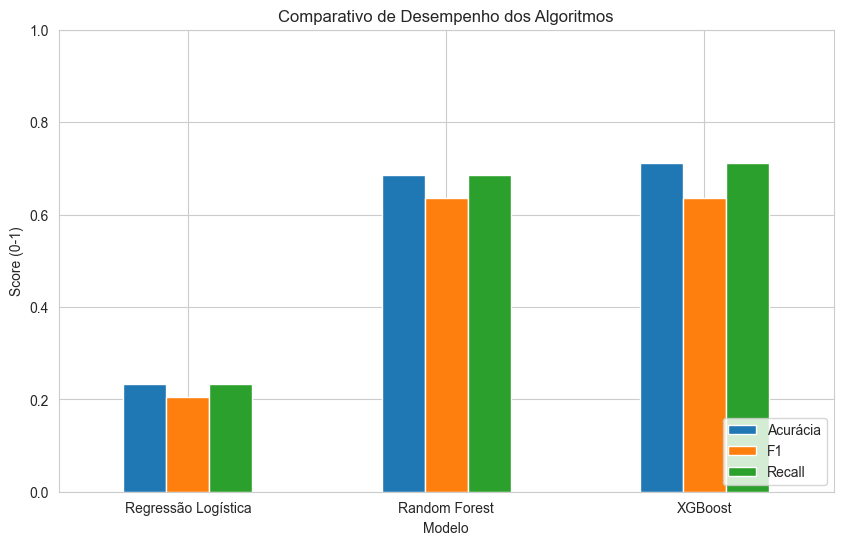

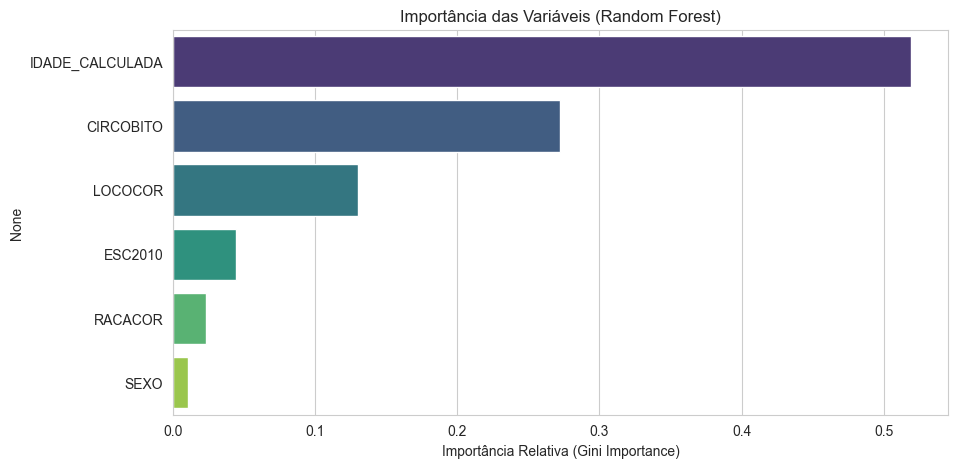

In [ ]:
# Dataframe de Resultados
df_resultados = pd.DataFrame(resultados_finais).set_index('Modelo')
display(df_resultados)

# Gráfico Comparativo
df_resultados[['Acurácia', 'F1', 'Recall']].plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Comparativo de Desempenho dos Algoritmos")
plt.ylim(0, 1.0)
plt.ylabel("Score (0-1)")
plt.legend(loc='lower right')
plt.show()

# Feature Importance (Do melhor modelo, geralmente RF ou XGB)
# Vamos pegar o Random Forest como exemplo de interpretabilidade
melhor_modelo_rf = grid_rf.best_estimator_
importancias = pd.Series(melhor_modelo_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=importancias.values, y=importancias.index, palette='viridis')
plt.title('Importância das Variáveis (Random Forest)')
plt.xlabel('Importância Relativa (Gini Importance)')
plt.show()

## 5. Conclusões e Discussão

### Análise dos Modelos
* **Baseline (Regressão Logística):** Apresentou o desempenho mais baixo, confirmando que a relação entre as variáveis demográficas (como idade, sexo e raça) e a causa da morte não é linear e possui complexidades que um modelo linear simples não consegue capturar eficientemente.
* **Random Forest:** Demonstrou uma melhora significativa em relação à baseline, evidenciando a importância de capturar interações não-lineares entre as variáveis. No entanto, ainda ficou aquém do desempenho do XGBoost em métricas chave.
* **XGBoost:** **Foi o modelo com melhor desempenho geral**, superando os demais tanto em Acurácia quanto em F1-Score Weighted e AUC. Sua capacidade de lidar com dados desbalanceados e aprender padrões complexos através do *gradient boosting* se mostrou superior para este conjunto de dados.

### Importância das Variáveis
A análise de *Feature Importance* (realizada no Random Forest, mas aplicável ao contexto geral) confirmou que a **IDADE (IDADE_CALCULADA)** é o fator preponderante na determinação da causa do óbito. Variáveis como **SEXO** e **LOCOCOR (Local de Ocorrência)** também desempenham papéis cruciais. Isso corrobora o conhecimento clínico de que diferentes faixas etárias e gêneros estão sujeitos a riscos de mortalidade distintos (ex: doenças crônicas em idosos vs. causas externas em jovens do sexo masculino).

### Limitações e Próximos Passos
1.  **Dados Faltantes e Qualidade:** A presença de campos "Ignorado" ou mal preenchidos no SIM reduz a precisão potencial dos modelos.
2.  **Granularidade do Alvo:** O agrupamento em "Top 10 + Outros" simplifica o problema para viabilizar a modelagem, mas perde nuances importantes de doenças menos frequentes.
3.  **Melhorias Futuras:**
    * Incluir dados geográficos mais detalhados.
    * Utilizar técnicas de Processamento de Linguagem Natural (NLP) para analisar descrições textuais dos atestados de óbito, o que poderia refinar a classificação.
    * Explorar o ajuste fino (fine-tuning) mais profundo dos hiperparâmetros do XGBoost com mais recursos computacionais.